In [60]:
%reload_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.morphology import binary_closing

plt.rcParams['figure.figsize'] = (10, 8)
plt.set_cmap('gray')

from keract import get_activations, display_activations, display_heatmaps, get_gradients_of_activations, get_gradients_of_trainable_weights

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from subtle.dnn.generators.unet2d import GeneratorUNet2D
import subtle.utils.io as suio
from subtle.data_loaders.slice_loader import SliceLoader
import subtle.subtle_loss as suloss
import subtle.subtle_plot as suplot
import subtle.subtle_preprocess as supre
import subtle.subtle_metrics as sumetrics
from subtle.dnn.helpers import clear_keras_memory, set_keras_memory

<Figure size 720x576 with 0 Axes>

In [2]:
fpath_data = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO56.h5'
slice_idx = 75
data, data_mask = suio.load_file(fpath_data, params={'h5_key': 'all'})
# data, data_mask = np.load(fpath_data)

In [3]:
clear_keras_memory()
set_keras_memory(1.0)

loss_function = suloss.mixed_loss(l1_lambda=1.0, ssim_lambda=0.0)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]

In [5]:
model = GeneratorUNet2D(
            num_channel_input=14, num_channel_output=1,
            img_rows=240, img_cols=240,
            loss_function=loss_function,
            metrics_monitor=metrics_monitor,
            lr_init=0.001,
            verbose=2,
            checkpoint_file='/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg_pf3.checkpoint')
model.load_weights()

Building unet2d model...
Tensor("model_input_1:0", shape=(?, 240, 240, 14), dtype=float32)
Tensor("relu_conv_enc_1_2_1/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("maxpool_1_1/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_conv_enc_2_2_1/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2_1/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2_1/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3_1/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center_1/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center_1/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2_1/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1_1/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3_2_1/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("cat_2_1/concat:0", shape=(?, 120, 120, 192), dtype=float32

In [6]:
model.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        (None, 240, 240, 14) 0                                            
__________________________________________________________________________________________________
conv_enc_1_0 (Conv2D)           (None, 240, 240, 32) 4064        model_input[0][0]                
__________________________________________________________________________________________________
relu_conv_enc_1_0 (Activation)  (None, 240, 240, 32) 0           conv_enc_1_0[0][0]               
__________________________________________________________________________________________________
conv_enc_1_1 (Conv2D)           (None, 240, 240, 32) 9248        relu_conv_enc_1_0[0][0]          
____________________________________________________________________________________________

In [7]:
predgen = SliceLoader(
    data_list=[fpath_data],
    file_ext=fpath_data.split('/')[-1].split('.')[1],
    batch_size=1,
    shuffle=False,
    verbose=0,
    slices_per_input=7,
    resize=240,
    slice_axis=[0],
    brain_only=False
)

In [8]:
y_pred = model.model.predict_generator(
    generator=predgen,
    max_queue_size=16,
    workers=1,
    use_multiprocessing=False,
    verbose=1
)


196/196 [==============================] - 3s 16ms/step


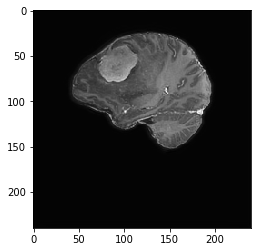

In [9]:
plt.set_cmap('gray')
plt.imshow(y_pred[slice_idx, ..., 0])

['model_input', 'conv_enc_1_0', 'relu_conv_enc_1_0', 'conv_enc_1_1', 'relu_conv_enc_1_1', 'conv_enc_1_2', 'relu_conv_enc_1_2', 'maxpool_1', 'conv_enc_2_0', 'relu_conv_enc_2_0', 'conv_enc_2_1', 'relu_conv_enc_2_1', 'conv_enc_2_2', 'relu_conv_enc_2_2', 'maxpool_2', 'conv_enc_3_0', 'relu_conv_enc_3_0', 'conv_enc_3_1', 'relu_conv_enc_3_1', 'conv_enc_3_2', 'relu_conv_enc_3_2', 'maxpool_3', 'conv_center', 'relu_conv_center', 'add_center', 'upsample_2', 'cat_1', 'conv_dec_2_0', 'relu_conv_dec_2_0', 'conv_dec_2_1', 'relu_conv_dec_2_1', 'conv_dec_2_2', 'relu_conv_dec_2_2', 'upsample_3', 'cat_2', 'conv_dec_3_0', 'relu_conv_dec_3_0', 'conv_dec_3_1', 'relu_conv_dec_3_1', 'conv_dec_3_2', 'relu_conv_dec_3_2', 'upsample_4', 'cat_3', 'conv_dec_4_0', 'relu_conv_dec_4_0', 'conv_dec_4_1', 'relu_conv_dec_4_1', 'conv_dec_4_2', 'relu_conv_dec_4_2', 'model_output', 'linear_model_output']


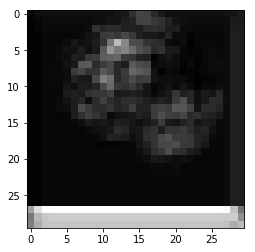

In [11]:
net_ip, net_op = predgen.__getitem__(slice_idx)

lname = 'add_center'

activations = get_activations(model.model, net_ip, layer_name='add_center')
act_ar = activations['add_center_1'][0]
rms = np.sqrt(np.mean(act_ar ** 2, axis=2))

plt.imshow(rms)

layer_names = [l.name for l in model.model.layers]
print(layer_names)

activations (1, 30, 30, 2) 


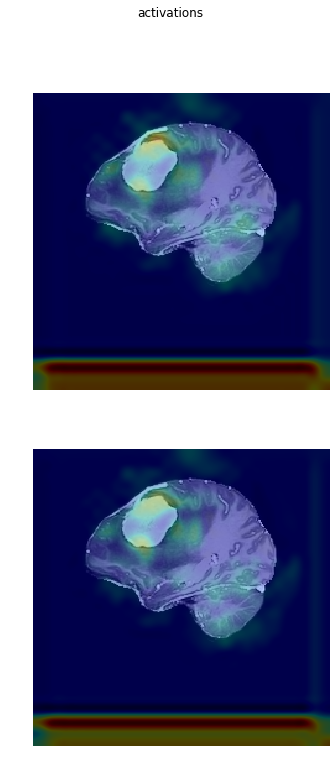

In [12]:
act = activations['add_center_1'][0]
act_sub_rms = np.sqrt(np.mean(act ** 2, axis=2))
act_sub_mean = np.mean(act, axis=2)

act_final = np.array([act_sub_rms, act_sub_mean]).transpose(1, 2, 0)[None, ...]

hmap_img = data_mask[slice_idx, 2]

act_sub_hmap = {'activations': act_final}
display_heatmaps(act_sub_hmap, hmap_img)

In [13]:
actvn = Image.fromarray(act_sub_rms)
actvn_rs = np.array(actvn.resize((240, 240), Image.LANCZOS))

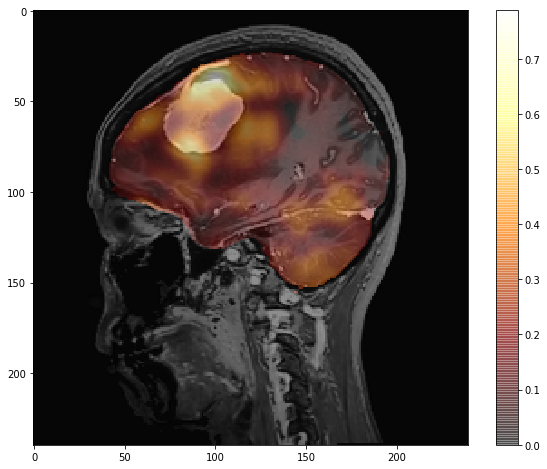

In [16]:
bmask = binary_closing(hmap_img > 0.2)
actvn_mask = (actvn_rs * bmask)
actvn_mask[actvn_mask < 0.05] = 0.0

data_disp = data[slice_idx, 2]

plt.imshow(1.5 * data_disp, cmap='gray', vmin=data_disp.min(), vmax=data_disp.max())
plt.imshow(actvn_mask, alpha=0.45, cmap='afmhot')

plt.colorbar()

In [73]:
grads = get_gradients_of_activations(model.model, net_ip, net_op)
grad_img = grads['maxpool_2_1'][0]
grad_max = np.sqrt(np.mean(grad_img ** 2, axis=2))
gmax_disp = Image.fromarray(grad_max)
gmax_disp = np.array(gmax_disp.resize((240, 240), Image.LANCZOS))

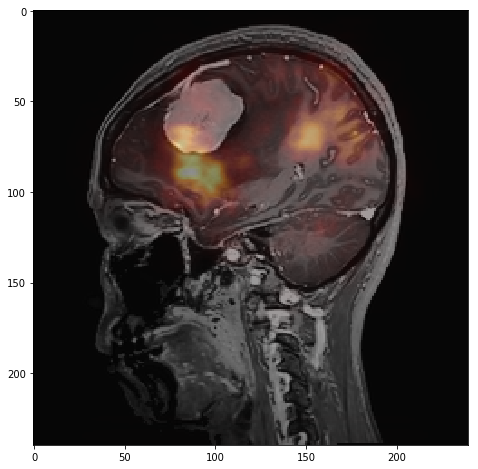

In [74]:
plt.imshow(1.5 * data_disp, cmap='gray', vmin=data_disp.min(), vmax=data_disp.max())
plt.imshow(gmax_disp, alpha=0.4, cmap='afmhot')